#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, X pst, 3 enzymes, one sample per instance, multiple psts per instance, test how many psts can have in one instances, how computing time depends on N p::f for 40 and 80 samples

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [5]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [12]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['p_occupancy']

,phosphosite,sample,value,prob
0,p0,s1,dec,0.534836
1,p0,s10,dec,0.886022
2,p0,s100,inc,0.939162
3,p0,s11,inc,0.629953
4,p0,s12,dec,0.624732
...,...,...,...,...
95,p0,s95,dec,0.711932
96,p0,s96,dec,0.913534
97,p0,s97,dec,0.845633
98,p0,s98,inc,0.887979


In [67]:
# duplicate data['p_occupancy'] * n and replace p0 in the new df with pn
# use pd.concat
n = 1
new_occ = data['p_occupancy'].copy()
for i in range(1, n):
    new_phos = data['p_occupancy'].copy()
    new_phos['phosphosite'] = new_phos['phosphosite'].replace('p0', 'p' + str(i))
    new_occ = pd.concat([new_occ, new_phos], ignore_index=True)
new_occ

,phosphosite,sample,value,prob
0,p0,s1,dec,0.534836
1,p0,s10,dec,0.886022
2,p0,s100,inc,0.939162
3,p0,s11,inc,0.629953
4,p0,s12,dec,0.624732
...,...,...,...,...
95,p0,s95,dec,0.711932
96,p0,s96,dec,0.913534
97,p0,s97,dec,0.845633
98,p0,s98,inc,0.887979


Splitting data into training/testing

In [68]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.6))
print(train)
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = data['e_activity'][data['e_activity']['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = new_occ[new_occ['sample'].isin(train)].reset_index(drop=True)

['s34', 's33', 's72', 's79', 's77', 's75', 's99', 's2', 's5', 's44', 's89', 's28', 's100', 's16', 's58', 's65', 's17', 's54', 's63', 's18', 's84', 's35', 's73', 's95', 's30', 's6', 's68', 's70', 's71', 's39', 's66', 's94', 's20', 's91', 's81', 's31', 's69', 's82', 's50', 's86', 's22', 's1', 's3', 's25', 's85', 's90', 's64', 's96', 's27', 's9', 's23', 's78', 's98', 's32', 's4', 's53', 's29', 's51', 's87', 's14']


In [69]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [70]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
evidence_dict = {}
for s in samples:
    evidence = []
    for predicate in predicates:
        evid_generator = build.ProblogStatementGenerator(predicates[predicate])
        evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    evidence_dict[s] = evidence

In [71]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o2.pl', 'w') as f:
    for s in evidence_dict:
        for e in evidence_dict[s]:
            f.write(e + '\n')
        f.write('--------------------' + '\n')

LFI

In [72]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 1
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o2.pl {DIR}evidence_o2.pl -O {DIR}p_model_o2.pl --logger {DIR}log_o2-p1-s60.txt -k ddnnf -v -n {max_iter}'
os.system(cmd)

-2138.489050645395 [0.00060771, 0.97520358, 0.00044495, 0.92104427, 0.0797746, 0.08217274, 0.0007024, 0.00072025, 0.3110029, 0.03339105, 0.01354286, 0.00010266, 0.80308265, 0.13185787, 0.00053146, 0.00047119, 0.00246498, 0.75544375, 0.01414663, 0.00037482, 0.00041346, 0.94345319, 0.00050856, 0.21593194, 0.00059265, 0.00206342, 0.96728751, 0.55385902, 0.83910875, 0.00060165, 0.96037851, 0.61147231, 0.00062155, 0.18018017, 0.00074901, 0.8199064, 0.98887911, 0.91057148, 0.00088631, 0.87921052, 0.0005092, 0.87151177, 0.00098557, 0.12692742, 0.00128225, 0.88280445, 0.05832953, 0.81453996, 0.01417763, 0.7542672, 0.00045659, 0.69024557, 0.00055556, 0.00041725, 0.00039253, 0.41785422, 0.15628346, 0.28088666, 0.0005308, 0.87744786, 0.00082894, 0.25391732, 0.00073163, 0.82928993, 0.00052083, 0.00053073, 0.00051845, 0.81109272, 0.14171319, 0.71970195, 0.23864194, 0.00067376, 0.34441407, 0.00033955, 0.17583448, 0.94176521, 0.00050023, 0.00052416, 0.00097523, 0.00090495, 0.32155488, 0.16905738, 0.8

0

In [11]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o2.pl -o {DIR}p_model_o2_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s14)::e_activity(e1,s14,base); t(0.33,e1,s14)::e_activity(e1,s14,dec); t(0.33,e1,s14)::e_activity(e1,s14,inc).\n0.741::e_ksea(e1,s14,base) :- e_activity(e1,s14,base).\n0.258::e_ksea(e1,s14,base) :- e_activity(e1,s14,dec).\n0.258::e_ksea(e1,s14,base) :- e_activity(e1,s14,inc).\nt(0.33,e2,s14)::e_activity(e2,s14,base); t(0.33,e2,s14)::e_activity(e2,s14,dec); t(0.33,e2,s14)::e_activity(e2,s14,inc).\n0.1188::e_ksea(e2,s14,inc) :- e_activity(e2,s14,base).\n0.001::e_ksea(e2,s14,inc) :- e_activity(e2,s14,dec).\n0.7623::e_ksea(e2,s14,inc) :- e_activity(e2,s14,inc).\nt(0.33,e3,s14)::e_activity(e3,s14,base); t(0.33,e3,s14)::e_activity(e3,s14,dec); t(0.33,e3,s14)::e_activity(e3,s14,inc).\n0.7715::e_ksea(e3,s14,base) :- e_activity(e3,s14,base).\n0.2275::e_ksea(e3,s14,base) :- e_activity(e3,s14,dec).\n0.2275::e_ksea(e3,s14,base) :- e_activity(e3,s14,inc).\nt(0.7,e1,p0)::occ_dec(p0,s14) :- e_activity(e1,s14,dec).\nt(0.7,e2,p0)::occ_dec(p0,s14) :- e_activity(e2,s14,dec).\nt(0.7,e3,p

256

In [6]:
# DONE add to csv file for model training
n_evidence = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
n_pst = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_pfacts = np.array([32, 52, 72, 92, 112, 132, 152, 172, 192, 212])
n_pfacts_e = np.array([36, 57, 78, 99, 120, 141, 162, 183, 204, 225])
n_params = np.array([54, 90, 126, 162, 198, 234, 270, 306, 342, 378])
n_pfacts_cross = np.array([17, 34, 51, 68, 85, 102, 119, 136, 153, 170])
n_params_cross = np.array([33, 42, 51, 60, 69, 78, 87, 96, 105, 114])
t_compile_60 = np.array([3.680502, 9.148256, 13.117279, 17.111094, 18.840654, 21.621466, 24.745413, 28.334631, 33.889700, 35.934473])
t_eval_60 = np.array([30.450537,  383.782035,  761.074239,  874.227993, 1029.429375, 1323.152808, 1811.468154, 2421.07242 , 3158.26086 , 4052.910564])
t_total_60 = t_compile_60 + t_eval_60
t_compile_30 = np.array([2.283181, 5.229598, 7.791580, 9.729065, 10.733852, 13.326829, 13.851359, 16.502953, 20.164595, 19.897662])
t_total_30 = np.array([18.4, 187.7, 383.4, 445.5, 519.8, 723.1, 928.8, 1221.7, 1703.0, 1967.9])
t_eval_30 = t_total_30 - t_compile_30

Predicted y-value for x = 1000: 1950.2739519097445s = 32.504565865162405min = 0.5417427644193734h
Predicted y-value for x = 1000: 3427.5364130598387s = 57.125606884330644min = 0.9520934480721774h


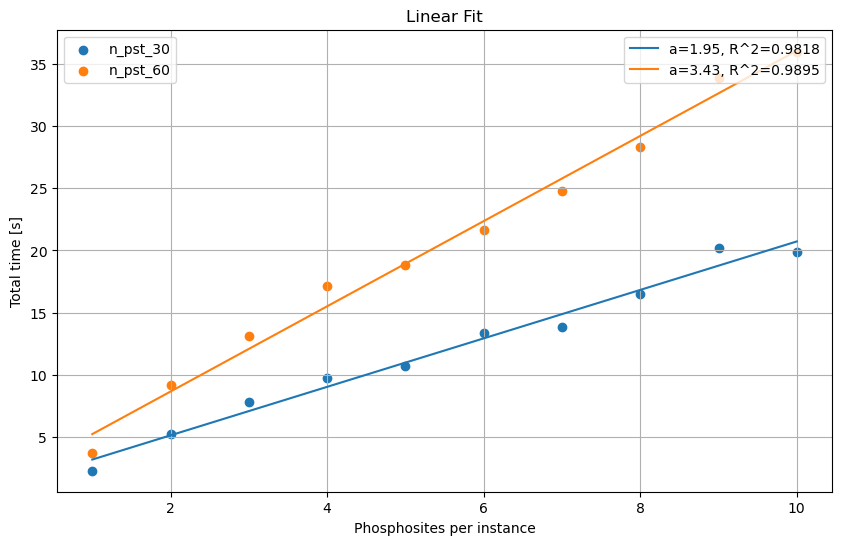

In [8]:
x_features = {'n_pst_30': n_pst, 'n_pst_60': n_pst}
y_time = {'n_pst_30': t_compile_30, 'n_pst_60': t_compile_60}
viz.plot_multiple_time_lin(x_features, y_time, 'Phosphosites per instance', 'Total time [s]', 1000)

n_pfacts_30 - Predicted y-value for x = 100: 449.9586666456118s = 7.499311110760197min = 0.12498851851266994h
n_pfacts_e_30 - Predicted y-value for x = 100: 394.38552598721185s = 6.573092099786864min = 0.10955153499644774h
n_params_30 - Predicted y-value for x = 100: 186.3987800412495s = 3.106646334020825min = 0.051777438900347084h
n_pfacts_60 - Predicted y-value for x = 100: 863.1418402511663s = 14.385697337519439min = 0.23976162229199063h
n_pfacts_e_60 - Predicted y-value for x = 100: 756.0204131009752s = 12.600340218349588min = 0.21000567030582645h
n_params_60 - Predicted y-value for x = 100: 373.4986727529376s = 6.2249778792156265min = 0.10374963132026044h


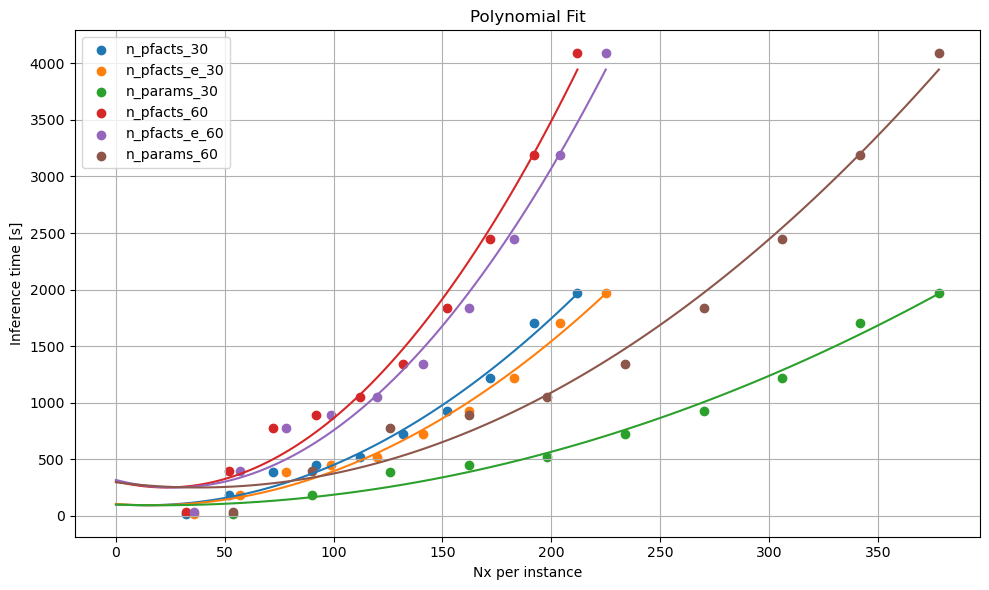

In [19]:
x_features = {'n_pfacts_30': n_pfacts, 'n_pfacts_e_30': n_pfacts_e, 'n_params_30': n_params,
              'n_pfacts_60': n_pfacts, 'n_pfacts_e_60': n_pfacts_e, 'n_params_60': n_params}
y_time = {'n_pfacts_30': t_total_30, 'n_pfacts_e_30': t_total_30, 'n_params_30': t_total_30,
          'n_pfacts_60': t_total_60, 'n_pfacts_e_60': t_total_60, 'n_params_60': t_total_60}
viz.plot_multiple_time_poly(x_features, y_time, 'Nx per instance', 'Inference time [s]', 100)